<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Pytorch_NET_Multitasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#create a model class
class Model(nn.Module):
  #Input (Tasks) random array of 9 units
  def __init__(self, in_tasks=9, in_stim=9, hidden= 100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    # print("Task Hidden Weight Shape:", self.task_hidden.weight)
    # print("Task Output Weight Shape:", self.task_out.weight.shape)
    # print("Stimulus Hidden Weight Shape:", self.stim_hidden.weight.shape)
    # print("Hidden Output Weight Shape:", self.hidden_out.weight.shape)

    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):
    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    # print("Shape of hidden_out output:", self.hidden_out(h_act).shape)
    # print("Shape of task_out output:", self.task_out(taskData).shape)

    return h_act, out_act

  def reset_parameters(self):
        for param in self.parameters():
            if param.requires_grad:
                nn.init.uniform_(param, -0.1, 0.1)



#Train Online Method using back propagation
def trainOnline(model, iterations, stimulusData, taskData, trainData):
     criterion = nn.MSELoss()
     optimizer = torch.optim.SGD(model.parameters(), lr=model.coeff)

     MSE_log = [0]
     MSE_patterns_log = [0]

     with tqdm(total=iterations) as pbar:  # Initialize the progress bar
        for i in range(iterations):
            order = torch.randperm(stimulusData.size(0))
            stimulusData = stimulusData[order]
            taskData = taskData[order]
            trainData = trainData[order]

            mse_values = []

            for dset in range(stimulusData.size(0)):
                optimizer.zero_grad()
                h_act, out_act = model(taskData[dset], stimulusData[dset])
                loss = criterion(out_act, trainData[dset])
                loss.backward()
                optimizer.step()
                mse_values.append(loss.item())

            mean_mse = sum(mse_values) / len(mse_values)
            MSE_log.append(mean_mse)
            MSE_patterns_log.append(mse_values)

            pbar.update(1)  # Update the progress bar

            if mean_mse < model.thresh:
                break

            if i == 0 or i == iterations - 1:  # Print only the first and last MSE error logs
                print(f"Iteration {i}: MSE = {mean_mse}")
                print("MSE Patterns:", MSE_patterns_log[i])

     return MSE_log, MSE_patterns_log


# Define Advantage Actor-Critic (A2C) training method
def a2c_train(model, optimizer, taskData, stimulusData, reward, value_target, entropy_beta=0.01):

   # model.train()
    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # Compute advantage
    advantage = reward - value_target

    # Compute actor loss
    actor_loss = -(log_probs * advantage.detach()).mean()

    # Compute critic loss (value function loss)
    critic_loss = 0.5 * advantage.pow(2).mean()

    # Compute total loss
    total_loss = actor_loss + critic_loss - entropy_beta * (log_probs * outputs).sum()

    total_loss.backward()
    optimizer.step()

    return total_loss.item(), reward.item(), value_target.item()


# Using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()

    loss.backward()
    optimizer.step()

    return loss.item()



# Define the Q-learning algorithm
class QLearning:
    def __init__(self, model, learning_rate=0.1, gamma=0.9, epsilon=0.1):
        self.model = model
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def train(self, taskData, stimulusData, target):
        # Convert inputs to tensors
        #taskData_tensor = torch.tensor(taskData, dtype=torch.float32)
        #stimulusData_tensor = torch.tensor(stimulusData, dtype=torch.float32)

        #  Get current Q-value
        _, current_Q = self.model(taskData, stimulusData)

        # Calculate target Q-value
        target_tensor = torch.tensor(target, dtype=torch.float32)
        target_Q = current_Q.clone()
        target_Q[0][target_tensor.argmax()] = target_tensor.max().item()

        # Compute loss using mean squared error
        loss = nn.MSELoss()(current_Q, target_Q.detach())

        # Backpropagation
        self.model.zero_grad()
        loss.backward()

        # Update weights
        with torch.no_grad():
            for param in self.model.parameters():
                param.data -= self.learning_rate * param.grad

    def choose_action(self, taskData, stimulusData):
        # Convert inputs to tensors
        #taskData_tensor = torch.tensor(taskData, dtype=torch.float32)
        #stimulusData_tensor = torch.tensor(stimulusData, dtype=torch.float32)

        # Forward pass to get Q-values
        _, Q_values = self.model(taskData, stimulusData)

        # Epsilon-greedy action selection
        if numpy.random.rand() < self.epsilon:
            action = numpy.random.randint(0, Q_values.shape[1])  # Random action
        else:
            action = Q_values.argmax().item()  # Greedy action

        return action


def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [ ]:
#create an instance for Model --> Backpropagation learned Model
model= Model()
model.reset_parameters
print(model)

Model(
  (task_hidden): Linear(in_features=9, out_features=100, bias=True)
  (stim_hidden): Linear(in_features=9, out_features=100, bias=True)
  (task_out): Linear(in_features=9, out_features=9, bias=True)
  (hidden_out): Linear(in_features=100, out_features=9, bias=True)
)


In [ ]:
# Create an empty DataFrame with 3 columns and 9 rows
df = pd.DataFrame(index=range(9), columns=['stimulus', 'task', 'output'])

In [ ]:
#Pick a manual seed for randomization for the input values
#torch.manual_seed(3407)
#taskData= torch.rand(1,5)
t=numpy.array([0,1,1,0,1])
taskData= torch.from_numpy(t).unsqueeze(0).to(torch.float32)
print(taskData)


z=numpy.array([0,1,1])
stimulusData= torch.from_numpy(z).unsqueeze(0).to(torch.float32)
print(stimulusData)


#torch.manual_seed(3407)
#trainData = torch.randn(1, 3)

y=numpy.array([0,1,0])
trainData= torch.from_numpy(y).unsqueeze(0).to(torch.float32)
print(trainData)

tensor([[0., 1., 1., 0., 1.]])
tensor([[0., 1., 1.]])
tensor([[0., 1., 0.]])


In [ ]:
model(taskData, stimulusData)

(tensor([[0.0702, 0.1210, 0.1557, 0.1105, 0.1468, 0.0985, 0.1115, 0.1648, 0.1514,
          0.1816, 0.0861, 0.2003, 0.1458, 0.1229, 0.1950, 0.0695, 0.0759, 0.1760,
          0.0923, 0.1815, 0.1873, 0.0961, 0.1312, 0.1514, 0.0826, 0.0865, 0.1499,
          0.1793, 0.1444, 0.1796, 0.1012, 0.1469, 0.0799, 0.0943, 0.1693, 0.1355,
          0.1386, 0.0780, 0.0964, 0.0948, 0.1165, 0.1437, 0.0811, 0.1275, 0.0975,
          0.1006, 0.1015, 0.0748, 0.1553, 0.1564, 0.0733, 0.0938, 0.1062, 0.1211,
          0.1012, 0.1148, 0.0877, 0.1053, 0.1375, 0.1202, 0.1397, 0.1115, 0.1294,
          0.1226, 0.1945, 0.1426, 0.1596, 0.0809, 0.0869, 0.0996, 0.1372, 0.1273,
          0.1367, 0.1078, 0.1524, 0.0773, 0.1072, 0.0675, 0.1445, 0.1745, 0.1024,
          0.0872, 0.0845, 0.1811, 0.1430, 0.1295, 0.0966, 0.1259, 0.0701, 0.1685,
          0.0710, 0.1738, 0.0703, 0.1310, 0.1581, 0.0831, 0.0585, 0.1473, 0.1803,
          0.0769]], grad_fn=<SigmoidBackward0>),
 tensor([[0.0968, 0.0688, 0.0829]], grad_fn=<Sigm

In [ ]:
print("Size of taskData:", taskData.size())
print("Size of stimulusData:", stimulusData.size())
print("Size of trainData:", trainData.size())


In [ ]:
MSE_log, MSE_patterns_log = trainOnline(model, 100, stimulusData, taskData, trainData)

#print("MSE Log:", MSE_log)
#print("MSE Patterns Log:", MSE_patterns_log)

100%|██████████| 100/100 [00:00<00:00, 1057.35it/s]

Iteration 0: MSE = 0.29448869824409485
MSE Patterns: 0
Iteration 99: MSE = 0.0038277904968708754
MSE Patterns: [0.003868606174364686]


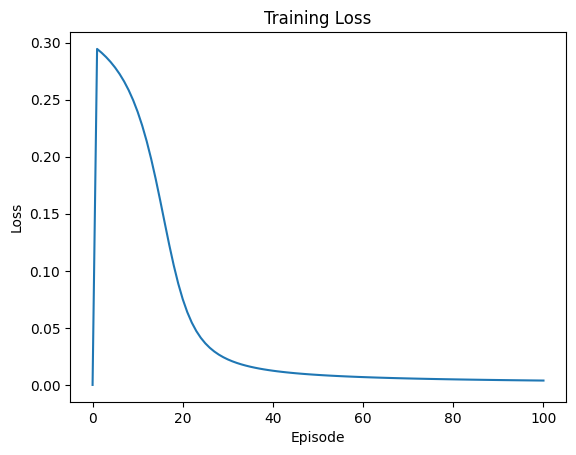

In [ ]:
plot_losses(MSE_log)

In [ ]:
#create an instance for Model --> Reinforcement learned Model -A2C
model_2 = Model()
model_2.reset_parameters
print(model_2)


Model(
  (task_hidden): Linear(in_features=5, out_features=100, bias=True)
  (stim_hidden): Linear(in_features=3, out_features=100, bias=True)
  (task_out): Linear(in_features=5, out_features=3, bias=True)
  (hidden_out): Linear(in_features=100, out_features=3, bias=True)
)


In [ ]:
model_2(taskData, stimulusData)

(tensor([[0.1543, 0.1947, 0.1685, 0.1457, 0.0735, 0.0799, 0.0703, 0.1057, 0.1694,
          0.1709, 0.1555, 0.0838, 0.0929, 0.1039, 0.1751, 0.1432, 0.1050, 0.0865,
          0.0857, 0.0962, 0.1426, 0.1034, 0.0930, 0.0947, 0.1325, 0.1130, 0.1886,
          0.1256, 0.0820, 0.1088, 0.1007, 0.1259, 0.1816, 0.1205, 0.1553, 0.0848,
          0.1406, 0.1012, 0.1438, 0.1923, 0.1570, 0.0758, 0.1318, 0.1237, 0.1205,
          0.0738, 0.1713, 0.1924, 0.1452, 0.1321, 0.0833, 0.1024, 0.0985, 0.1777,
          0.1331, 0.1253, 0.0759, 0.0892, 0.1440, 0.0996, 0.1580, 0.0994, 0.0678,
          0.1678, 0.0981, 0.1173, 0.1329, 0.2044, 0.2170, 0.0692, 0.0837, 0.0811,
          0.1614, 0.1413, 0.1589, 0.1150, 0.2290, 0.1312, 0.1365, 0.0978, 0.1062,
          0.1804, 0.0978, 0.1341, 0.1572, 0.1652, 0.0655, 0.1087, 0.2392, 0.0917,
          0.1423, 0.0952, 0.1336, 0.0994, 0.1343, 0.1066, 0.0724, 0.1631, 0.0926,
          0.0805]], grad_fn=<SigmoidBackward0>),
 tensor([[0.0808, 0.0935, 0.1052]], grad_fn=<Sigm

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)



def train_A2C(num_episodes=100, log_interval=1):
    losses=[]
    for episode in range(1, num_episodes + 1):
        # Generate random task and stimulus data
        taskData = torch.rand(1, 5)
        stimulusData = torch.tensor([[0, 1, 1]], dtype=torch.float32)

        # Generate random training data
        trainData = torch.randn(1, 3)

        # Forward pass through model
        _, outputs = model_2(taskData, stimulusData)

        # Define reward
        reward = torch.sum(outputs * trainData)

        # Compute value estimate
        value_target = torch.mean(outputs * trainData)

        # Train using A2C
        loss, reward_val, value_est = a2c_train(model_2, optimizer, taskData, stimulusData, reward, value_target)
        losses.append(loss)
        # Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.2f} | Reward: {reward_val:.2f} | Value Estimate: {value_est:.2f}")

    plot_losses(losses)

Episode 1/100 | Loss: -0.18 | Reward: -0.12 | Value Estimate: -0.04
Episode 2/100 | Loss: 0.00 | Reward: -0.00 | Value Estimate: -0.00
Episode 3/100 | Loss: 0.17 | Reward: 0.10 | Value Estimate: 0.03
Episode 4/100 | Loss: 0.57 | Reward: 0.33 | Value Estimate: 0.11
Episode 5/100 | Loss: 0.09 | Reward: 0.05 | Value Estimate: 0.02
Episode 6/100 | Loss: 0.29 | Reward: 0.17 | Value Estimate: 0.06
Episode 7/100 | Loss: -0.04 | Reward: -0.03 | Value Estimate: -0.01
Episode 8/100 | Loss: -0.03 | Reward: -0.02 | Value Estimate: -0.01
Episode 9/100 | Loss: -0.08 | Reward: -0.05 | Value Estimate: -0.02
Episode 10/100 | Loss: -0.07 | Reward: -0.05 | Value Estimate: -0.02
Episode 11/100 | Loss: -0.06 | Reward: -0.04 | Value Estimate: -0.01
Episode 12/100 | Loss: -0.05 | Reward: -0.03 | Value Estimate: -0.01
Episode 13/100 | Loss: 0.40 | Reward: 0.23 | Value Estimate: 0.08
Episode 14/100 | Loss: -0.11 | Reward: -0.07 | Value Estimate: -0.02
Episode 15/100 | Loss: -0.06 | Reward: -0.04 | Value Estima

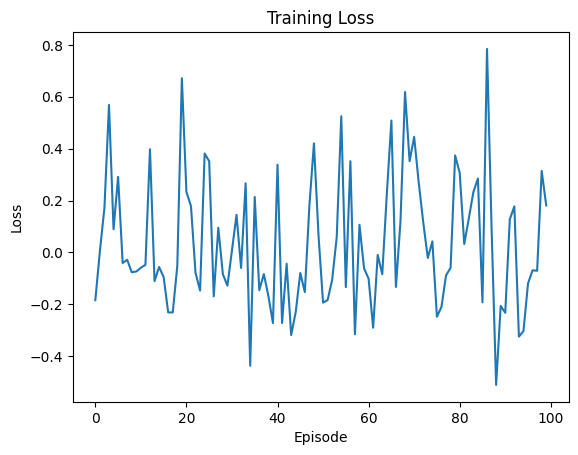

Output after training: tensor([[0.0773, 0.0991, 0.0932]])


In [ ]:
# Train the model
train_A2C()

# Test the trained model output
with torch.no_grad():
    taskData = torch.rand(1, 5)
    stimulusData = torch.tensor([[0, 1, 1]], dtype=torch.float32)
    _, outputs = model_2(taskData, stimulusData)
    print("Output after training:", outputs)

In [ ]:
# Create model instance for Reinforce algorithm
model_3 = Model()
model_3.reset_parameters
model_3(taskData, stimulusData)

(tensor([[0.0827, 0.0983, 0.0716, 0.1041, 0.1682, 0.1270, 0.2128, 0.2265, 0.1111,
          0.1138, 0.1063, 0.0974, 0.1565, 0.1833, 0.1458, 0.1060, 0.1697, 0.1162,
          0.1348, 0.1244, 0.1626, 0.1267, 0.1144, 0.1279, 0.1205, 0.1615, 0.1623,
          0.1084, 0.0984, 0.0751, 0.1036, 0.0985, 0.0643, 0.1157, 0.0925, 0.1179,
          0.1230, 0.2147, 0.0709, 0.0638, 0.0875, 0.0909, 0.0989, 0.1893, 0.1063,
          0.0642, 0.1044, 0.1521, 0.1500, 0.1431, 0.0908, 0.1154, 0.1995, 0.1408,
          0.1559, 0.1231, 0.1556, 0.1029, 0.0868, 0.0744, 0.0923, 0.1809, 0.1432,
          0.0749, 0.1232, 0.1790, 0.0751, 0.0952, 0.1093, 0.1507, 0.1164, 0.1619,
          0.1550, 0.1359, 0.1368, 0.0845, 0.1271, 0.0871, 0.1770, 0.1296, 0.1244,
          0.1289, 0.1177, 0.1048, 0.1877, 0.1433, 0.0838, 0.0958, 0.0947, 0.0859,
          0.1717, 0.1062, 0.0908, 0.0943, 0.0903, 0.1623, 0.1108, 0.2406, 0.0866,
          0.1384]], grad_fn=<SigmoidBackward0>),
 tensor([[0.1490, 0.1155, 0.0805]], grad_fn=<Sigm

Episode 1/100 | Loss: 0.2534
Episode 2/100 | Loss: 0.2481
Episode 3/100 | Loss: 0.2429
Episode 4/100 | Loss: 0.2377
Episode 5/100 | Loss: 0.2327
Episode 6/100 | Loss: 0.2278
Episode 7/100 | Loss: 0.2230
Episode 8/100 | Loss: 0.2183
Episode 9/100 | Loss: 0.2137
Episode 10/100 | Loss: 0.2092
Episode 11/100 | Loss: 0.2048
Episode 12/100 | Loss: 0.2005
Episode 13/100 | Loss: 0.1962
Episode 14/100 | Loss: 0.1921
Episode 15/100 | Loss: 0.1880
Episode 16/100 | Loss: 0.1841
Episode 17/100 | Loss: 0.1802
Episode 18/100 | Loss: 0.1764
Episode 19/100 | Loss: 0.1727
Episode 20/100 | Loss: 0.1691
Episode 21/100 | Loss: 0.1656
Episode 22/100 | Loss: 0.1621
Episode 23/100 | Loss: 0.1587
Episode 24/100 | Loss: 0.1554
Episode 25/100 | Loss: 0.1522
Episode 26/100 | Loss: 0.1490
Episode 27/100 | Loss: 0.1460
Episode 28/100 | Loss: 0.1429
Episode 29/100 | Loss: 0.1400
Episode 30/100 | Loss: 0.1371
Episode 31/100 | Loss: 0.1343
Episode 32/100 | Loss: 0.1316
Episode 33/100 | Loss: 0.1289
Episode 34/100 | Lo

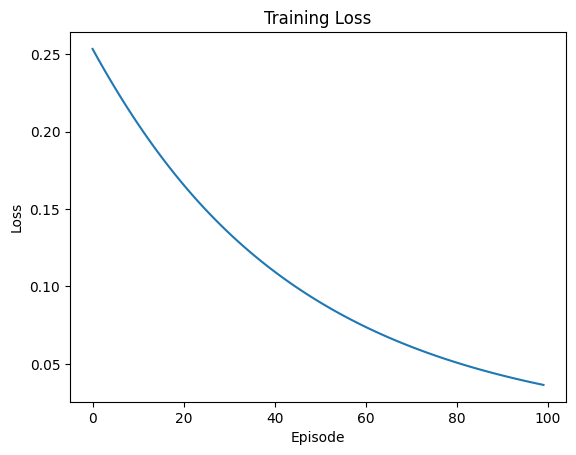

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Define training loop
def train_Rein(num_episodes=100, log_interval=1):
    losses = []  # To store losses at each episode
    for episode in range(1, num_episodes + 1):

        # Forward pass
        _, outputs = model_3(taskData, stimulusData)

        # Define reward
        reward = torch.sum(outputs * trainData)

        # Train using REINFORCE
        loss = reinforce_train(model_3, optimizer, taskData, stimulusData, reward)
        losses.append(loss)
        # Logging
        if episode % log_interval == 0:
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.4f}")
    plot_losses(losses)
# Train the model
train_Rein()

In [ ]:
# Instantiate the model, Q-learning algorithm
model_4 = Model()
model_4.reset_parameters
model_4(taskData, stimulusData)


(tensor([[0.0958, 0.1317, 0.0837, 0.1901, 0.1686, 0.1431, 0.1505, 0.0841, 0.1055,
          0.1053, 0.0955, 0.0734, 0.1774, 0.0975, 0.1274, 0.1384, 0.1326, 0.0979,
          0.0738, 0.0959, 0.1171, 0.1019, 0.1086, 0.0710, 0.0881, 0.1701, 0.1043,
          0.1618, 0.0842, 0.1782, 0.1542, 0.1524, 0.1553, 0.1289, 0.1463, 0.1565,
          0.2041, 0.1472, 0.0906, 0.1870, 0.0800, 0.0801, 0.0714, 0.1073, 0.1376,
          0.0673, 0.0969, 0.1323, 0.0890, 0.0913, 0.1498, 0.0756, 0.1081, 0.1104,
          0.0868, 0.1472, 0.1299, 0.1710, 0.1317, 0.0778, 0.1285, 0.1378, 0.1401,
          0.1355, 0.1239, 0.1943, 0.1534, 0.1769, 0.1520, 0.1429, 0.0602, 0.1275,
          0.1081, 0.1157, 0.1859, 0.1245, 0.0804, 0.1179, 0.1476, 0.0801, 0.1696,
          0.2055, 0.1471, 0.1725, 0.0679, 0.1287, 0.1378, 0.1480, 0.0916, 0.1670,
          0.0847, 0.0843, 0.1343, 0.1842, 0.1113, 0.0801, 0.1685, 0.1620, 0.1038,
          0.0989]], grad_fn=<SigmoidBackward0>),
 tensor([[0.1034, 0.1359, 0.0939]], grad_fn=<Sigm

In [ ]:
# Main training loop
def Q_training():


    # Initialize Q-learning agent
    agent = QLearning(model_4)

    # Sample input data
    #taskData = torch.rand(1, 5)
    #stimulusData = np.array([0, 1, 1])
    target = numpy.array([0, 1, 0])

    # Training loop
    num_episodes = 100
    losses = []  # To store losses at each episode

    for episode in range(num_episodes):
        # Choose action
        action = agent.choose_action(taskData, stimulusData)

        #assuming target is given directly as reward
        agent.train(taskData, stimulusData, target)

        _, current_Q = model_4(taskData, stimulusData)
        target_tensor = torch.tensor(target, dtype=torch.float32)
        target_Q = current_Q.clone()
        target_Q[0][target_tensor.argmax()] = target_tensor.max().item()
        loss = nn.MSELoss()(current_Q, target_Q.detach())
        losses.append(loss.item())
        # Update epsilon for epsilon-greedy strategy
        # agent.epsilon = max(0.1, agent.epsilon * 0.99)

        # Print progress
        if (episode + 1) % 1 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item()}")


    plot_losses(losses)

Episode 1/100, Loss: 0.2457415610551834
Episode 2/100, Loss: 0.24245209991931915
Episode 3/100, Loss: 0.2389838844537735
Episode 4/100, Loss: 0.23532851040363312
Episode 5/100, Loss: 0.23147766292095184
Episode 6/100, Loss: 0.22742384672164917
Episode 7/100, Loss: 0.22316016256809235
Episode 8/100, Loss: 0.21868111193180084
Episode 9/100, Loss: 0.2139824777841568
Episode 10/100, Loss: 0.2090621143579483
Episode 11/100, Loss: 0.20392024517059326
Episode 12/100, Loss: 0.19855983555316925
Episode 13/100, Loss: 0.19298726320266724
Episode 14/100, Loss: 0.18721240758895874
Episode 15/100, Loss: 0.18124938011169434
Episode 16/100, Loss: 0.17511659860610962
Episode 17/100, Loss: 0.1688367873430252
Episode 18/100, Loss: 0.16243697702884674
Episode 19/100, Loss: 0.15594817698001862
Episode 20/100, Loss: 0.14940470457077026
Episode 21/100, Loss: 0.14284352958202362
Episode 22/100, Loss: 0.1363030970096588
Episode 23/100, Loss: 0.12982217967510223
Episode 24/100, Loss: 0.12343883514404297
Episode

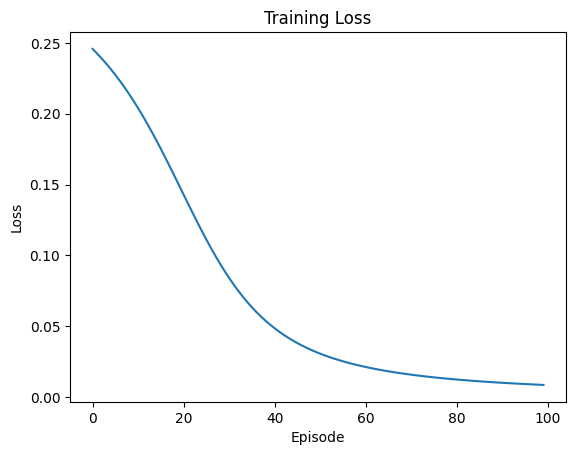

In [ ]:
Q_training()